# Data-driven Modelling of Chlorophyll-a from Nitrogen and Phosphorus Content

In [1]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization._optimization_history import _get_optimization_history_info_list

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from time import time
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
start = time()
df = pd.read_csv("chlor.csv")
df.head()

,Chl_a,Phy,NO2,NO3,NH4,PO4,Site,Bay,Depth
0,6.66,0.74,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.097
1,6.45,0.78,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
2,6.27,0.77,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
3,6.13,0.58,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004
4,6.10,0.57,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004


<Figure size 1080x1080 with 0 Axes>

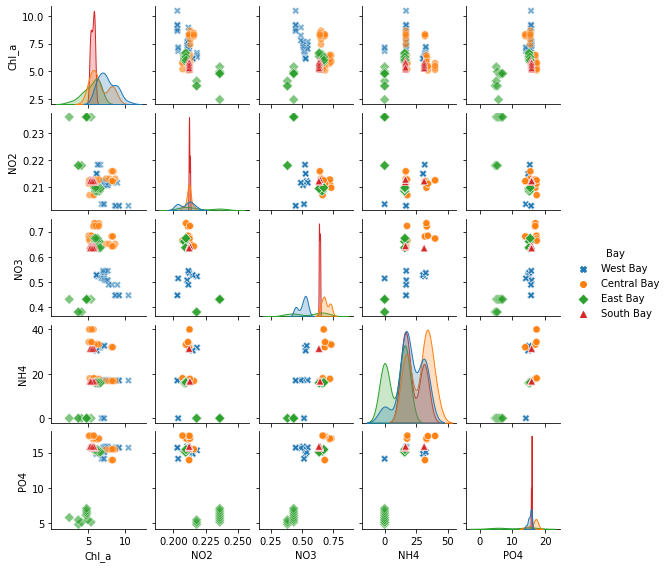

In [3]:
df.dropna(inplace=True)
df.drop(['Phy'], axis=1, inplace=True)

plt.figure(figsize=(15,15))
sns.pairplot(df[['Chl_a','NO2','NO3','NH4','PO4','Bay']], 
             height=1.6, hue="Bay", markers=['X','o','D','^'],
             plot_kws={"s": 50,'alpha': 0.6}) 
plt.show()

## Exploratory Data Analysis

Explained variance ratio:    [0.66299171 0.19398164 0.11577687 0.02724979]
Cumulative percent variance: [ 66.29917075  85.69733458  97.27502114 100.        ]
      1st PC    2nd PC   3rd PC     4th PC       Bay
0   0.129604 -0.709483  1.24923  -0.424575  West Bay
1   0.129604 -0.709483  1.24923  -0.424575  West Bay
2   0.129604 -0.709483  1.24923  -0.424575  West Bay
3  0.0398513 -0.346665  1.12411 -0.0814897  West Bay
4  0.0398513 -0.346665  1.12411 -0.0814897  West Bay


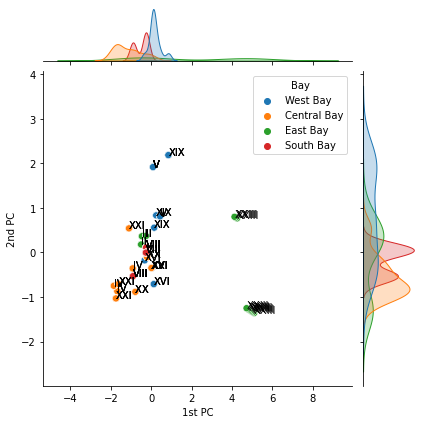

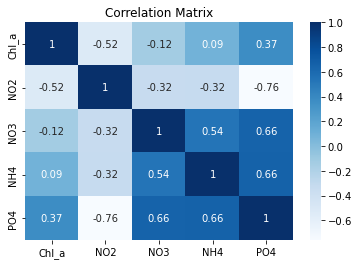

In [4]:
X, y = df.iloc[:,1:5].to_numpy(), df['Chl_a'].to_numpy()

# Perform Standard Scaling then PCA on predictors, X

pca = make_pipeline(StandardScaler(), PCA())
X_pca = pca.fit(X).transform(X)
var = pca[1].explained_variance_ratio_
print("Explained variance ratio:    %s" % str(var))
print("Cumulative percent variance: %s" % str(np.cumsum(var)*100))

# Plot the first 2 principal components
pca_df = pd.DataFrame(data=np.c_[X_pca, df["Bay"]],
                      columns=['1st PC','2nd PC','3rd PC','4th PC','Bay'])
print(pca_df.head())
sns.jointplot(data=pca_df, x="1st PC", y="2nd PC", hue="Bay", s=50)
for txt, i in zip(df['Site'], range(len(X_pca))):
    plt.annotate(txt, (X_pca[i,0], X_pca[i,1]))
plt.show()
corr_matrix = df[['Chl_a','NO2','NO3','NH4','PO4']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix show that there is little correlation for dimensionality reduction to be effective. The 95% variance is explained by 3 predictors. 

## Train-test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=df['Site'])
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

## Baseline Linear Regression on 4 Predictors

R2 on Train Set: 0.4537909157124268
R2 on Test Set: 0.28757577902328124
Coefficients: 
 [-2.43300555e-15] [[-0.08106809 -0.61488113 -0.26227254  0.92924602]]
Coefficient for:  NO_2, NO_3, NH_4, PO_4


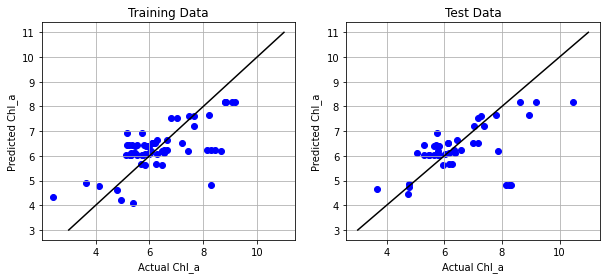

In [6]:
lin_mdl = LinearRegression().fit(X_train_scaled, y_train_scaled)
print(f"R2 on Train Set: {lin_mdl.score(X_train_scaled,y_train_scaled)}")
print(f"R2 on Test Set: {lin_mdl.score(X_test_scaled,y_test_scaled)}")
print("Coefficients: \n", lin_mdl.intercept_, lin_mdl.coef_)
print("Coefficient for:  NO_2, NO_3, NH_4, PO_4")

y_train_pred = scaler_y.inverse_transform(lin_mdl.predict(X_train_scaled))
y_test_pred = scaler_y.inverse_transform(lin_mdl.predict(X_test_scaled))

plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(121)
plt.scatter(y_train, y_train_pred, color='b')
plt.plot([3, 11],[3, 11],'k')
plt.xlabel('Actual Chl_a')
plt.ylabel('Predicted Chl_a')
plt.title('Training Data')
plt.grid()
plt.subplot(122)
plt.scatter(y_test, y_test_pred, color='b')
plt.plot([3, 11],[3, 11],'k')
plt.xlabel('Actual Chl_a')
plt.ylabel('Predicted Chl_a')
plt.title('Test Data')
plt.grid()
plt.show()

Baseline linear regression model shows poor predictive performance on Chl-a. Linear coefficients show the order of feature importance.

## Prediction of Chl-a using Optuna: Model Selection and Tuning

In [7]:
def create_model(trial, model_type):
    #model_type = trial.suggest_categorical('model_type', ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR'])
    
    if model_type == 'KRR':
        alpha = trial.suggest_float('KRR_alpha',0.01, 100, log=True)
        kernel = trial.suggest_categorical('KRR_kernel',
                                           ['rbf', 'polynomial', 'cosine', 'laplacian', 'sigmoid'])
        model = KernelRidge(alpha=alpha, kernel=kernel)
        
    if model_type == 'kNN':
        wts = trial.suggest_categorical('kNN_weights', ['uniform', 'distance'])
        n_neigh = trial.suggest_int('kNN_n_neighbors',1,20)
        model = KNeighborsRegressor(weights=wts,n_neighbors=n_neigh)
    
    if model_type == 'SVR':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_float('SVR-C', 0.1, 100, log=True)
        gamma = trial.suggest_float('SVR-gamma', 0.1, 100, log=True)
        epsi = trial.suggest_float('SVR-epsilon', 0.1, 100, log=True)
        degree = trial.suggest_int('SVR-degree', 1, 3, step=1)
        model = SVR(kernel=kernel, C=C, epsilon=epsi, gamma=gamma, degree=degree)
    
    if model_type == 'MLP':
        params = {
                    'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, log=True),
                    'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=1),
                    'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=1),
                    'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
                 }

        model = MLPRegressor(hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
                             learning_rate_init=params['learning_rate_init'],
                             activation=params['activation'],
                             random_state=1,
                             max_iter=100)
        
    if model_type == 'RF':
        n_estimators = trial.suggest_int('RF_n_estimators',10,200)
        crit = trial.suggest_categorical('RF_criterion', ['friedman_mse', 'squared_error', 'absolute_error'])
        model = RandomForestRegressor(n_estimators=n_estimators, criterion=crit, random_state=42)
        
    if model_type == 'GBR':
        n_estimators = trial.suggest_int('GBR_n_estimators',10,200)
        max_depth = trial.suggest_int('GBR_max_depth',1,50)
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    if model_type == 'GPR':
        alpha = trial.suggest_float('GPR_alpha',0.01, 100, log=True)
        noise_level = trial.suggest_float('GPR_noise',0.01, 10, log=True)
        kernel_type = trial.suggest_categorical('GPR_kernel', ['rbf','matern','dot'])
        if kernel_type == 'rbf':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + RBF(length_scale=length_scale),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)
        if kernel_type == 'matern':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            nu = trial.suggest_float('GP_nu',0.5, 5, step=0.5)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + Matern(length_scale=length_scale,nu=nu),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)
        if kernel_type == 'dot':
            sigma = trial.suggest_float('GPR_dot_sigma', 0, 10)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + DotProduct(sigma_0=sigma),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)

    if trial.should_prune():
            raise optuna.TrialPruned()

    return model

def objective(trial, model_type):
    model = create_model(trial, model_type)
    scores = cross_val_score(model, 
                             X_train_scaled, 
                             y_train_scaled.ravel(), 
                             cv=5,
                             scoring='neg_mean_squared_error')
    return np.mean(scores)


sampler = TPESampler(seed=42)
best_mdls = []
studies = []
for model_type in ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR']:
    study = optuna.create_study(direction='maximize', 
                                sampler=sampler)
    optuna_start = time()
    study.optimize(lambda trial: objective(trial, model_type), n_trials=150)
    studies.append(study)
    best_params = study.best_params
    print("\n\nBest parameters: ", best_params)
    total_time = time()-optuna_start
    print("Runtime: %.4f sec" % total_time)
    best_mdls.append(create_model(study.best_trial, model_type))

[I 2023-09-18 15:54:59,192] A new study created in memory with name: no-name-f48e8356-a89f-4074-8a0b-dbf6e13735a6
[I 2023-09-18 15:54:59,294] Trial 0 finished with value: -0.35122720811758507 and parameters: {'KRR_alpha': 0.31489116479568624, 'KRR_kernel': 'rbf'}. Best is trial 0 with value: -0.35122720811758507.
[I 2023-09-18 15:54:59,317] Trial 1 finished with value: -0.43846511179511954 and parameters: {'KRR_alpha': 0.017073967431528128, 'KRR_kernel': 'sigmoid'}. Best is trial 0 with value: -0.35122720811758507.
[I 2023-09-18 15:54:59,330] Trial 2 finished with value: -1.2360531007497508 and parameters: {'KRR_alpha': 21.368329072358772, 'KRR_kernel': 'sigmoid'}. Best is trial 0 with value: -0.35122720811758507.
[I 2023-09-18 15:54:59,335] Trial 3 finished with value: -0.37839436567708506 and parameters: {'KRR_alpha': 0.5342937261279778, 'KRR_kernel': 'polynomial'}. Best is trial 0 with value: -0.35122720811758507.
[I 2023-09-18 15:54:59,349] Trial 4 finished with value: -0.393987192

[I 2023-09-18 15:54:59,778] Trial 37 finished with value: -0.8760815342402474 and parameters: {'KRR_alpha': 0.12073245822160457, 'KRR_kernel': 'sigmoid'}. Best is trial 32 with value: -0.21134544357267648.
[I 2023-09-18 15:54:59,786] Trial 38 finished with value: -0.29246813183933446 and parameters: {'KRR_alpha': 0.3264338561478084, 'KRR_kernel': 'laplacian'}. Best is trial 32 with value: -0.21134544357267648.
[I 2023-09-18 15:54:59,804] Trial 39 finished with value: -0.21134199002857348 and parameters: {'KRR_alpha': 0.02457638410094328, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:54:59,816] Trial 40 finished with value: -0.4083962584727727 and parameters: {'KRR_alpha': 0.07163168130315276, 'KRR_kernel': 'polynomial'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:54:59,833] Trial 41 finished with value: -0.211369756684763 and parameters: {'KRR_alpha': 0.022864838030407935, 'KRR_kernel': 'laplacian'}. Best is tri

[I 2023-09-18 15:55:00,302] Trial 74 finished with value: -0.21271946728112004 and parameters: {'KRR_alpha': 0.01428036123733689, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,318] Trial 75 finished with value: -0.2113599088230918 and parameters: {'KRR_alpha': 0.023182510157393844, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,333] Trial 76 finished with value: -2.383885174873349 and parameters: {'KRR_alpha': 0.018596015158687286, 'KRR_kernel': 'sigmoid'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,346] Trial 77 finished with value: -0.7854746561981203 and parameters: {'KRR_alpha': 0.09305320927490794, 'KRR_kernel': 'cosine'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,349] Trial 78 finished with value: -0.272890902198434 and parameters: {'KRR_alpha': 0.010243833677883512, 'KRR_kernel': 'rbf'}. Best is trial 39 wit

[I 2023-09-18 15:55:00,828] Trial 111 finished with value: -0.21134429167161137 and parameters: {'KRR_alpha': 0.02500141051383787, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,841] Trial 112 finished with value: -0.21136380501392188 and parameters: {'KRR_alpha': 0.026028332711116178, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,853] Trial 113 finished with value: -0.21172406408548966 and parameters: {'KRR_alpha': 0.018743231041306287, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,870] Trial 114 finished with value: -0.21338001807163104 and parameters: {'KRR_alpha': 0.04176979358992359, 'KRR_kernel': 'laplacian'}. Best is trial 39 with value: -0.21134199002857348.
[I 2023-09-18 15:55:00,885] Trial 115 finished with value: -0.45597887553743616 and parameters: {'KRR_alpha': 0.03542046392334712, 'KRR_kernel': 'polynomial'}

[I 2023-09-18 15:55:01,346] Trial 148 finished with value: -0.211780209465071 and parameters: {'KRR_alpha': 0.031764953555188394, 'KRR_kernel': 'laplacian'}. Best is trial 124 with value: -0.21134198202629814.
[I 2023-09-18 15:55:01,361] Trial 149 finished with value: -0.21227484358001206 and parameters: {'KRR_alpha': 0.015876026957212304, 'KRR_kernel': 'laplacian'}. Best is trial 124 with value: -0.21134198202629814.
[I 2023-09-18 15:55:01,362] A new study created in memory with name: no-name-a9b23a99-f1c4-41cb-996f-a6e16fd2f2b2
[I 2023-09-18 15:55:01,414] Trial 0 finished with value: -0.8735556302690559 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 17}. Best is trial 0 with value: -0.8735556302690559.
[I 2023-09-18 15:55:01,421] Trial 1 finished with value: -0.7307119795675334 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 11}. Best is trial 1 with value: -0.7307119795675334.
[I 2023-09-18 15:55:01,429] Trial 2 finished with value: -0.26100783898697494 



Best parameters:  {'KRR_alpha': 0.024451252684332455, 'KRR_kernel': 'laplacian'}
Runtime: 2.1666 sec


[I 2023-09-18 15:55:01,575] Trial 17 finished with value: -0.2535706501175062 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 13}. Best is trial 4 with value: -0.24165258805251408.
[I 2023-09-18 15:55:01,583] Trial 18 finished with value: -0.24237523187548865 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 17}. Best is trial 4 with value: -0.24165258805251408.
[I 2023-09-18 15:55:01,597] Trial 19 finished with value: -0.24290441764058412 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 7}. Best is trial 4 with value: -0.24165258805251408.
[I 2023-09-18 15:55:01,598] Trial 20 finished with value: -0.251686533453614 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 20}. Best is trial 4 with value: -0.24165258805251408.
[I 2023-09-18 15:55:01,615] Trial 21 finished with value: -0.24165258805251408 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 15}. Best is trial 4 with value: -0.24165258805251408.
[I 2023-09-18 15:55

[I 2023-09-18 15:55:02,055] Trial 56 finished with value: -0.24165258805251408 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 15}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,069] Trial 57 finished with value: -0.2535706501175062 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 13}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,081] Trial 58 finished with value: -0.251686533453614 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 20}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,096] Trial 59 finished with value: -0.8503550581920118 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 16}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,103] Trial 60 finished with value: -0.24901878063848662 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 19}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 1

[I 2023-09-18 15:55:02,595] Trial 95 finished with value: -0.23900262754269921 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 16}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,599] Trial 96 finished with value: -0.2535991261672424 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 4}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,615] Trial 97 finished with value: -0.8735556302690559 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 17}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,631] Trial 98 finished with value: -0.24165258805251408 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 15}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:02,648] Trial 99 finished with value: -0.2477582796837098 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 14}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 1

[I 2023-09-18 15:55:03,135] Trial 134 finished with value: -0.24237523187548865 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 17}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:03,148] Trial 135 finished with value: -0.23900262754269921 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 16}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:03,164] Trial 136 finished with value: -0.24165258805251408 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 15}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:03,181] Trial 137 finished with value: -0.24454722217889713 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 18}. Best is trial 22 with value: -0.23900262754269921.
[I 2023-09-18 15:55:03,196] Trial 138 finished with value: -0.24237523187548865 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 17}. Best is trial 22 with value: -0.23900262754269921.
[I 20



Best parameters:  {'kNN_weights': 'distance', 'kNN_n_neighbors': 16}
Runtime: 1.9861 sec


[I 2023-09-18 15:55:03,552] Trial 12 finished with value: -0.6772420852025378 and parameters: {'kernel': 'poly', 'SVR-C': 4.675073621475286, 'SVR-gamma': 0.11126420880828487, 'SVR-epsilon': 0.8572481806001293, 'SVR-degree': 1}. Best is trial 6 with value: -0.6398573113373951.
[I 2023-09-18 15:55:03,564] Trial 13 finished with value: -0.8463742782486863 and parameters: {'kernel': 'poly', 'SVR-C': 0.13799657580650682, 'SVR-gamma': 1.2761733540559284, 'SVR-epsilon': 1.7026378215323732, 'SVR-degree': 1}. Best is trial 6 with value: -0.6398573113373951.
[I 2023-09-18 15:55:03,596] Trial 14 finished with value: -0.3513974839401397 and parameters: {'kernel': 'rbf', 'SVR-C': 9.193512321014962, 'SVR-gamma': 0.17573527620454096, 'SVR-epsilon': 0.3797321714340884, 'SVR-degree': 1}. Best is trial 14 with value: -0.3513974839401397.
[I 2023-09-18 15:55:03,617] Trial 15 finished with value: -0.27865695249556344 and parameters: {'kernel': 'rbf', 'SVR-C': 12.300348204688516, 'SVR-gamma': 0.25083181024

[I 2023-09-18 15:55:04,188] Trial 41 finished with value: -0.19750791217696204 and parameters: {'kernel': 'rbf', 'SVR-C': 18.005987334623843, 'SVR-gamma': 0.9182420626075831, 'SVR-epsilon': 0.16175768482606048, 'SVR-degree': 3}. Best is trial 31 with value: -0.1944885938625213.
[I 2023-09-18 15:55:04,211] Trial 42 finished with value: -0.22462325947808487 and parameters: {'kernel': 'rbf', 'SVR-C': 24.68952541909589, 'SVR-gamma': 0.7048564416939443, 'SVR-epsilon': 0.29545970911413555, 'SVR-degree': 3}. Best is trial 31 with value: -0.1944885938625213.
[I 2023-09-18 15:55:04,235] Trial 43 finished with value: -0.22697048011904108 and parameters: {'kernel': 'rbf', 'SVR-C': 66.12624626893792, 'SVR-gamma': 0.4262735996984099, 'SVR-epsilon': 0.1399059027638428, 'SVR-degree': 3}. Best is trial 31 with value: -0.1944885938625213.
[I 2023-09-18 15:55:04,259] Trial 44 finished with value: -0.20542760239558122 and parameters: {'kernel': 'rbf', 'SVR-C': 45.29805848409994, 'SVR-gamma': 0.3724624492

[I 2023-09-18 15:55:04,961] Trial 70 finished with value: -0.3343027811237892 and parameters: {'kernel': 'rbf', 'SVR-C': 31.05565760881912, 'SVR-gamma': 1.710488105937503, 'SVR-epsilon': 0.13340164252578215, 'SVR-degree': 3}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:04,986] Trial 71 finished with value: -0.19678383501264496 and parameters: {'kernel': 'rbf', 'SVR-C': 12.662614584921583, 'SVR-gamma': 1.1685533575855431, 'SVR-epsilon': 0.12061311986835727, 'SVR-degree': 3}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:05,010] Trial 72 finished with value: -0.20148680701975183 and parameters: {'kernel': 'rbf', 'SVR-C': 15.996596875111706, 'SVR-gamma': 0.949384015298314, 'SVR-epsilon': 0.20439087015280202, 'SVR-degree': 3}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:05,035] Trial 73 finished with value: -0.19364416616092606 and parameters: {'kernel': 'rbf', 'SVR-C': 20.7193010746832, 'SVR-gamma': 0.591355878

[I 2023-09-18 15:55:05,746] Trial 99 finished with value: -0.8019869975751217 and parameters: {'kernel': 'linear', 'SVR-C': 10.711196025537033, 'SVR-gamma': 1.2110874790573933, 'SVR-epsilon': 0.1129928265399446, 'SVR-degree': 2}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:05,764] Trial 100 finished with value: -0.20611545108295637 and parameters: {'kernel': 'rbf', 'SVR-C': 15.3137365311064, 'SVR-gamma': 0.39520350267787036, 'SVR-epsilon': 0.13960048681962237, 'SVR-degree': 3}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:05,795] Trial 101 finished with value: -0.19478311037118626 and parameters: {'kernel': 'rbf', 'SVR-C': 26.112252367173085, 'SVR-gamma': 0.7858256004628722, 'SVR-epsilon': 0.10000703484048334, 'SVR-degree': 3}. Best is trial 51 with value: -0.19358263302978934.
[I 2023-09-18 15:55:05,830] Trial 102 finished with value: -0.19307012600282975 and parameters: {'kernel': 'rbf', 'SVR-C': 19.78617739670687, 'SVR-gamma': 0.6

[I 2023-09-18 15:55:06,520] Trial 127 finished with value: -0.21634219623854722 and parameters: {'kernel': 'rbf', 'SVR-C': 38.76359224108041, 'SVR-gamma': 0.7740404866262338, 'SVR-epsilon': 0.11398053391543075, 'SVR-degree': 3}. Best is trial 113 with value: -0.1927598401360932.
[I 2023-09-18 15:55:06,545] Trial 128 finished with value: -0.19672395626181255 and parameters: {'kernel': 'rbf', 'SVR-C': 16.486033120142487, 'SVR-gamma': 0.5260459556658236, 'SVR-epsilon': 0.1296333660219566, 'SVR-degree': 3}. Best is trial 113 with value: -0.1927598401360932.
[I 2023-09-18 15:55:06,578] Trial 129 finished with value: -0.7801376500369215 and parameters: {'kernel': 'linear', 'SVR-C': 18.262781081680906, 'SVR-gamma': 0.36664296168165367, 'SVR-epsilon': 0.20251490910493808, 'SVR-degree': 3}. Best is trial 113 with value: -0.1927598401360932.
[I 2023-09-18 15:55:06,602] Trial 130 finished with value: -0.22364259419472526 and parameters: {'kernel': 'rbf', 'SVR-C': 11.478964436520185, 'SVR-gamma': 



Best parameters:  {'kernel': 'rbf', 'SVR-C': 18.706661783641433, 'SVR-gamma': 0.4990318697594256, 'SVR-epsilon': 0.16688034091906265, 'SVR-degree': 3}
Runtime: 3.8156 sec


[I 2023-09-18 15:55:07,456] Trial 0 finished with value: -0.28423859208696783 and parameters: {'learning_rate_init ': 0.010781845035122271, 'first_layer_neurons': 11, 'second_layer_neurons': 56, 'activation': 'tanh'}. Best is trial 0 with value: -0.28423859208696783.
[I 2023-09-18 15:55:07,731] Trial 1 finished with value: -0.21170234101859636 and parameters: {'learning_rate_init ': 0.011825328508422656, 'first_layer_neurons': 45, 'second_layer_neurons': 95, 'activation': 'tanh'}. Best is trial 1 with value: -0.21170234101859636.
[I 2023-09-18 15:55:07,997] Trial 2 finished with value: -0.3095727780446139 and parameters: {'learning_rate_init ': 0.05944028113410932, 'first_layer_neurons': 89, 'second_layer_neurons': 33, 'activation': 'tanh'}. Best is trial 1 with value: -0.21170234101859636.
[I 2023-09-18 15:55:08,202] Trial 3 finished with value: -0.4309296927800553 and parameters: {'learning_rate_init ': 0.0038810723164094817, 'first_layer_neurons': 32, 'second_layer_neurons': 18, 'ac

[I 2023-09-18 15:55:14,529] Trial 30 finished with value: -0.20568227645857462 and parameters: {'learning_rate_init ': 0.012742023687209671, 'first_layer_neurons': 23, 'second_layer_neurons': 54, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:14,794] Trial 31 finished with value: -0.19432921866006425 and parameters: {'learning_rate_init ': 0.0341056643658085, 'first_layer_neurons': 75, 'second_layer_neurons': 60, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:15,044] Trial 32 finished with value: -0.20103915427413072 and parameters: {'learning_rate_init ': 0.04856627401616444, 'first_layer_neurons': 76, 'second_layer_neurons': 71, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:15,326] Trial 33 finished with value: -0.40468493348659773 and parameters: {'learning_rate_init ': 0.025711880466134332, 'first_layer_neurons': 47, 'second_layer_neurons': 6

[I 2023-09-18 15:55:21,932] Trial 60 finished with value: -0.703437527514384 and parameters: {'learning_rate_init ': 0.0030182264170267956, 'first_layer_neurons': 70, 'second_layer_neurons': 53, 'activation': 'identity'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:22,253] Trial 61 finished with value: -0.24115809860915452 and parameters: {'learning_rate_init ': 0.021875753944745755, 'first_layer_neurons': 50, 'second_layer_neurons': 83, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:22,556] Trial 62 finished with value: -0.22844183575246074 and parameters: {'learning_rate_init ': 0.017626296557527944, 'first_layer_neurons': 44, 'second_layer_neurons': 89, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:22,807] Trial 63 finished with value: -0.2347813396204474 and parameters: {'learning_rate_init ': 0.029600825429667715, 'first_layer_neurons': 56, 'second_layer_neuron

[I 2023-09-18 15:55:29,818] Trial 90 finished with value: -0.24911953047581611 and parameters: {'learning_rate_init ': 0.010242934294567657, 'first_layer_neurons': 85, 'second_layer_neurons': 69, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:30,101] Trial 91 finished with value: -0.1936871063415853 and parameters: {'learning_rate_init ': 0.02353861570432867, 'first_layer_neurons': 64, 'second_layer_neurons': 80, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:30,338] Trial 92 finished with value: -0.19557319623968664 and parameters: {'learning_rate_init ': 0.02061517061446437, 'first_layer_neurons': 64, 'second_layer_neurons': 12, 'activation': 'relu'}. Best is trial 22 with value: -0.16782890997794875.
[I 2023-09-18 15:55:30,650] Trial 93 finished with value: -0.22154983225026278 and parameters: {'learning_rate_init ': 0.012413012058508558, 'first_layer_neurons': 73, 'second_layer_neurons': 8

[I 2023-09-18 15:55:38,464] Trial 119 finished with value: -0.254151967111521 and parameters: {'learning_rate_init ': 0.016699843302995593, 'first_layer_neurons': 26, 'second_layer_neurons': 71, 'activation': 'relu'}. Best is trial 101 with value: -0.1662039293244189.
[I 2023-09-18 15:55:38,772] Trial 120 finished with value: -0.19274189373875403 and parameters: {'learning_rate_init ': 0.025683706636116695, 'first_layer_neurons': 54, 'second_layer_neurons': 65, 'activation': 'relu'}. Best is trial 101 with value: -0.1662039293244189.
[I 2023-09-18 15:55:39,092] Trial 121 finished with value: -0.21790678117645737 and parameters: {'learning_rate_init ': 0.02401101390810967, 'first_layer_neurons': 54, 'second_layer_neurons': 66, 'activation': 'relu'}. Best is trial 101 with value: -0.1662039293244189.
[I 2023-09-18 15:55:39,350] Trial 122 finished with value: -0.22733604965608128 and parameters: {'learning_rate_init ': 0.02825354053036397, 'first_layer_neurons': 57, 'second_layer_neurons'

[I 2023-09-18 15:55:46,746] Trial 148 finished with value: -0.2201129470248786 and parameters: {'learning_rate_init ': 0.0297678824079237, 'first_layer_neurons': 43, 'second_layer_neurons': 73, 'activation': 'relu'}. Best is trial 101 with value: -0.1662039293244189.
[I 2023-09-18 15:55:47,061] Trial 149 finished with value: -0.33750265698965365 and parameters: {'learning_rate_init ': 0.021302988958947836, 'first_layer_neurons': 69, 'second_layer_neurons': 65, 'activation': 'relu'}. Best is trial 101 with value: -0.1662039293244189.
[I 2023-09-18 15:55:47,061] A new study created in memory with name: no-name-c86813a2-1363-4ec8-b84f-f6dbc776c1f6




Best parameters:  {'learning_rate_init ': 0.015333338068444533, 'first_layer_neurons': 69, 'second_layer_neurons': 79, 'activation': 'relu'}
Runtime: 39.8974 sec


[I 2023-09-18 15:55:47,986] Trial 0 finished with value: -0.23008011428375147 and parameters: {'RF_n_estimators': 161, 'RF_criterion': 'squared_error'}. Best is trial 0 with value: -0.23008011428375147.
[I 2023-09-18 15:55:48,229] Trial 1 finished with value: -0.23162578463237518 and parameters: {'RF_n_estimators': 47, 'RF_criterion': 'friedman_mse'}. Best is trial 0 with value: -0.23008011428375147.
[I 2023-09-18 15:55:49,034] Trial 2 finished with value: -0.22967208999608668 and parameters: {'RF_n_estimators': 133, 'RF_criterion': 'absolute_error'}. Best is trial 2 with value: -0.22967208999608668.
[I 2023-09-18 15:55:50,113] Trial 3 finished with value: -0.235031137670945 and parameters: {'RF_n_estimators': 184, 'RF_criterion': 'absolute_error'}. Best is trial 2 with value: -0.22967208999608668.
[I 2023-09-18 15:55:50,570] Trial 4 finished with value: -0.23287219199145878 and parameters: {'RF_n_estimators': 91, 'RF_criterion': 'friedman_mse'}. Best is trial 2 with value: -0.22967208

[I 2023-09-18 15:56:12,599] Trial 38 finished with value: -0.23008752904735172 and parameters: {'RF_n_estimators': 97, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:13,339] Trial 39 finished with value: -0.22821977450529066 and parameters: {'RF_n_estimators': 140, 'RF_criterion': 'squared_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:13,878] Trial 40 finished with value: -0.2297543460915783 and parameters: {'RF_n_estimators': 86, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:14,557] Trial 41 finished with value: -0.22657548705427494 and parameters: {'RF_n_estimators': 112, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:15,226] Trial 42 finished with value: -0.22640072941464084 and parameters: {'RF_n_estimators': 113, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: 

[I 2023-09-18 15:56:37,809] Trial 76 finished with value: -0.22859500753723455 and parameters: {'RF_n_estimators': 130, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:38,388] Trial 77 finished with value: -0.23105923209686519 and parameters: {'RF_n_estimators': 94, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:39,080] Trial 78 finished with value: -0.2263204758998055 and parameters: {'RF_n_estimators': 111, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:39,799] Trial 79 finished with value: -0.2286942710324591 and parameters: {'RF_n_estimators': 138, 'RF_criterion': 'squared_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:56:40,531] Trial 80 finished with value: -0.228431277090974 and parameters: {'RF_n_estimators': 119, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0

[I 2023-09-18 15:57:03,489] Trial 114 finished with value: -0.2281914359350788 and parameters: {'RF_n_estimators': 121, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:57:04,064] Trial 115 finished with value: -0.23105923209686519 and parameters: {'RF_n_estimators': 94, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:57:04,769] Trial 116 finished with value: -0.2278323185531586 and parameters: {'RF_n_estimators': 115, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:57:05,346] Trial 117 finished with value: -0.22679665839002 and parameters: {'RF_n_estimators': 110, 'RF_criterion': 'squared_error'}. Best is trial 35 with value: -0.2263204758998055.
[I 2023-09-18 15:57:06,103] Trial 118 finished with value: -0.22823515291012114 and parameters: {'RF_n_estimators': 126, 'RF_criterion': 'absolute_error'}. Best is trial 35 with value



Best parameters:  {'RF_n_estimators': 111, 'RF_criterion': 'absolute_error'}
Runtime: 100.0420 sec


[I 2023-09-18 15:57:27,441] Trial 0 finished with value: -0.2796433838206239 and parameters: {'GBR_n_estimators': 164, 'GBR_max_depth': 41}. Best is trial 0 with value: -0.2796433838206239.
[I 2023-09-18 15:57:27,780] Trial 1 finished with value: -0.2793563696552537 and parameters: {'GBR_n_estimators': 175, 'GBR_max_depth': 46}. Best is trial 1 with value: -0.2793563696552537.
[I 2023-09-18 15:57:28,003] Trial 2 finished with value: -0.27331556380736705 and parameters: {'GBR_n_estimators': 107, 'GBR_max_depth': 26}. Best is trial 2 with value: -0.27331556380736705.
[I 2023-09-18 15:57:28,330] Trial 3 finished with value: -0.2778415022187127 and parameters: {'GBR_n_estimators': 162, 'GBR_max_depth': 33}. Best is trial 2 with value: -0.27331556380736705.
[I 2023-09-18 15:57:28,616] Trial 4 finished with value: -0.28633905263820714 and parameters: {'GBR_n_estimators': 144, 'GBR_max_depth': 40}. Best is trial 2 with value: -0.27331556380736705.
[I 2023-09-18 15:57:28,988] Trial 5 finished 

[I 2023-09-18 15:57:34,558] Trial 41 finished with value: -0.2791342471451804 and parameters: {'GBR_n_estimators': 22, 'GBR_max_depth': 4}. Best is trial 38 with value: -0.2362648157626542.
[I 2023-09-18 15:57:34,626] Trial 42 finished with value: -0.24572261825529312 and parameters: {'GBR_n_estimators': 35, 'GBR_max_depth': 3}. Best is trial 38 with value: -0.2362648157626542.
[I 2023-09-18 15:57:34,709] Trial 43 finished with value: -0.26511782634048153 and parameters: {'GBR_n_estimators': 33, 'GBR_max_depth': 7}. Best is trial 38 with value: -0.2362648157626542.
[I 2023-09-18 15:57:34,807] Trial 44 finished with value: -0.2847945500882873 and parameters: {'GBR_n_estimators': 47, 'GBR_max_depth': 5}. Best is trial 38 with value: -0.2362648157626542.
[I 2023-09-18 15:57:34,914] Trial 45 finished with value: -0.34688298970849346 and parameters: {'GBR_n_estimators': 57, 'GBR_max_depth': 1}. Best is trial 38 with value: -0.2362648157626542.
[I 2023-09-18 15:57:35,009] Trial 46 finished w

[I 2023-09-18 15:57:39,828] Trial 82 finished with value: -0.28816684446578295 and parameters: {'GBR_n_estimators': 60, 'GBR_max_depth': 5}. Best is trial 68 with value: -0.2322959874981451.
[I 2023-09-18 15:57:39,970] Trial 83 finished with value: -0.24086345269683251 and parameters: {'GBR_n_estimators': 82, 'GBR_max_depth': 2}. Best is trial 68 with value: -0.2322959874981451.
[I 2023-09-18 15:57:40,125] Trial 84 finished with value: -0.295806482563936 and parameters: {'GBR_n_estimators': 79, 'GBR_max_depth': 4}. Best is trial 68 with value: -0.2322959874981451.
[I 2023-09-18 15:57:40,286] Trial 85 finished with value: -0.2790379570540406 and parameters: {'GBR_n_estimators': 95, 'GBR_max_depth': 1}. Best is trial 68 with value: -0.2322959874981451.
[I 2023-09-18 15:57:40,435] Trial 86 finished with value: -0.28702000044994136 and parameters: {'GBR_n_estimators': 67, 'GBR_max_depth': 6}. Best is trial 68 with value: -0.2322959874981451.
[I 2023-09-18 15:57:40,571] Trial 87 finished wi

[I 2023-09-18 15:57:44,936] Trial 122 finished with value: -0.37090701184078867 and parameters: {'GBR_n_estimators': 50, 'GBR_max_depth': 1}. Best is trial 101 with value: -0.23203086717175828.
[I 2023-09-18 15:57:45,068] Trial 123 finished with value: -0.23307122710651665 and parameters: {'GBR_n_estimators': 58, 'GBR_max_depth': 2}. Best is trial 101 with value: -0.23203086717175828.
[I 2023-09-18 15:57:45,198] Trial 124 finished with value: -0.2874246373121783 and parameters: {'GBR_n_estimators': 59, 'GBR_max_depth': 4}. Best is trial 101 with value: -0.23203086717175828.
[I 2023-09-18 15:57:45,331] Trial 125 finished with value: -0.26945386268999405 and parameters: {'GBR_n_estimators': 64, 'GBR_max_depth': 3}. Best is trial 101 with value: -0.23203086717175828.
[I 2023-09-18 15:57:45,484] Trial 126 finished with value: -0.27210751343376816 and parameters: {'GBR_n_estimators': 67, 'GBR_max_depth': 7}. Best is trial 101 with value: -0.23203086717175828.
[I 2023-09-18 15:57:45,590] Tri



Best parameters:  {'GBR_n_estimators': 61, 'GBR_max_depth': 2}
Runtime: 21.3664 sec


[I 2023-09-18 15:57:49,317] Trial 0 finished with value: -0.27328187773085827 and parameters: {'GPR_alpha': 0.013243445838637987, 'GPR_noise': 0.01294328655506425, 'GPR_kernel': 'rbf', 'GPR_length_scale': 0.36874809057925306}. Best is trial 0 with value: -0.27328187773085827.
[I 2023-09-18 15:57:49,701] Trial 1 finished with value: -1.0447773089800543 and parameters: {'GPR_alpha': 12.02193048491505, 'GPR_noise': 0.044408191026434445, 'GPR_kernel': 'rbf', 'GPR_length_scale': 0.3927027067477073}. Best is trial 0 with value: -0.27328187773085827.
[I 2023-09-18 15:57:52,109] Trial 2 finished with value: -0.510975258678103 and parameters: {'GPR_alpha': 1.4539199187561553, 'GPR_noise': 0.8171272700715593, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.0930827957371382, 'GP_nu': 4.0}. Best is trial 0 with value: -0.27328187773085827.
[I 2023-09-18 15:57:52,783] Trial 3 finished with value: -0.656228650428978 and parameters: {'GPR_alpha': 0.12115155843077678, 'GPR_noise': 0.20745039310086585, '

[I 2023-09-18 15:58:11,890] Trial 29 finished with value: -0.2628022801730133 and parameters: {'GPR_alpha': 0.046299797351240284, 'GPR_noise': 0.042230625166446836, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.06773657566280454, 'GP_nu': 5.0}. Best is trial 29 with value: -0.2628022801730133.
[I 2023-09-18 15:58:14,508] Trial 30 finished with value: -0.2635490037906927 and parameters: {'GPR_alpha': 0.03038578251734025, 'GPR_noise': 0.04013246922607486, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.06956706359025926, 'GP_nu': 5.0}. Best is trial 29 with value: -0.2628022801730133.
[I 2023-09-18 15:58:17,235] Trial 31 finished with value: -0.2636484929541126 and parameters: {'GPR_alpha': 0.027038484032468644, 'GPR_noise': 0.0356895008417268, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.07132311838761876, 'GP_nu': 5.0}. Best is trial 29 with value: -0.2628022801730133.
[I 2023-09-18 15:58:20,284] Trial 32 finished with value: -0.263648371266955 and parameters: {'GPR_alpha': 0.0285970156

[I 2023-09-18 15:59:11,385] Trial 56 finished with value: -0.2514255353978382 and parameters: {'GPR_alpha': 0.018713424957442205, 'GPR_noise': 0.03543418513747714, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.010253589460901458, 'GP_nu': 1.5}. Best is trial 56 with value: -0.2514255353978382.
[I 2023-09-18 15:59:12,398] Trial 57 finished with value: -0.6562287980127939 and parameters: {'GPR_alpha': 0.018413666935025563, 'GPR_noise': 0.022049748870112924, 'GPR_kernel': 'dot', 'GPR_dot_sigma': 1.8677675956604678}. Best is trial 56 with value: -0.2514255353978382.
[I 2023-09-18 15:59:13,301] Trial 58 finished with value: -0.2514255362421368 and parameters: {'GPR_alpha': 0.019044529330975626, 'GPR_noise': 0.034149276923190974, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.010056588186042699, 'GP_nu': 1.5}. Best is trial 56 with value: -0.2514255353978382.
[I 2023-09-18 15:59:14,197] Trial 59 finished with value: -0.25142553896764513 and parameters: {'GPR_alpha': 0.010644561556083107, 'GPR

[I 2023-09-18 15:59:41,587] Trial 83 finished with value: -0.24569348597890944 and parameters: {'GPR_alpha': 0.05265812926707985, 'GPR_noise': 0.2106098936846377, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.08842152870308195, 'GP_nu': 1.0}. Best is trial 82 with value: -0.23711107090715.
[I 2023-09-18 15:59:42,345] Trial 84 finished with value: -0.23723514969308673 and parameters: {'GPR_alpha': 0.04955866786221925, 'GPR_noise': 0.19725591731474326, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.05759915475713879, 'GP_nu': 0.5}. Best is trial 82 with value: -0.23711107090715.
[I 2023-09-18 15:59:43,113] Trial 85 finished with value: -0.23730589416543282 and parameters: {'GPR_alpha': 0.04867040513986685, 'GPR_noise': 0.20569814003912823, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.054890972066089484, 'GP_nu': 0.5}. Best is trial 82 with value: -0.23711107090715.
[I 2023-09-18 15:59:44,825] Trial 86 finished with value: -0.24573802851002005 and parameters: {'GPR_alpha': 0.0518643406309

[I 2023-09-18 16:00:08,884] Trial 110 finished with value: -0.24511808542182711 and parameters: {'GPR_alpha': 0.06347203015164186, 'GPR_noise': 0.32893401696818975, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.12624776459442666, 'GP_nu': 1.0}. Best is trial 91 with value: -0.23710531372746738.
[I 2023-09-18 16:00:09,525] Trial 111 finished with value: -0.2371494572498088 and parameters: {'GPR_alpha': 0.060243887125889406, 'GPR_noise': 0.49844891738039837, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.07825210554581111, 'GP_nu': 0.5}. Best is trial 91 with value: -0.23710531372746738.
[I 2023-09-18 16:00:10,031] Trial 112 finished with value: -0.2380490831528018 and parameters: {'GPR_alpha': 0.08244603854577322, 'GPR_noise': 0.5217381623484363, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.07759324196794684, 'GP_nu': 0.5}. Best is trial 91 with value: -0.23710531372746738.
[I 2023-09-18 16:00:10,848] Trial 113 finished with value: -0.23715481049781933 and parameters: {'GPR_alpha': 0.06

[I 2023-09-18 16:00:33,305] Trial 137 finished with value: -0.23784353610935266 and parameters: {'GPR_alpha': 0.07895629584124261, 'GPR_noise': 0.22915168921056348, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.1508237049512941, 'GP_nu': 0.5}. Best is trial 136 with value: -0.2371052282088791.
[I 2023-09-18 16:00:33,915] Trial 138 finished with value: -0.23710797169483633 and parameters: {'GPR_alpha': 0.05248354125069933, 'GPR_noise': 0.3451150042386359, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.12569439071135086, 'GP_nu': 0.5}. Best is trial 136 with value: -0.2371052282088791.
[I 2023-09-18 16:00:34,611] Trial 139 finished with value: -0.2371093599020769 and parameters: {'GPR_alpha': 0.05215312541012045, 'GPR_noise': 0.34980874594029443, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.1961785126986769, 'GP_nu': 0.5}. Best is trial 136 with value: -0.2371052282088791.
[I 2023-09-18 16:00:35,421] Trial 140 finished with value: -0.23833106756143754 and parameters: {'GPR_alpha': 0.0326



Best parameters:  {'GPR_alpha': 0.054720298236561875, 'GPR_noise': 0.2361102206495183, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.10446793379408148, 'GP_nu': 0.5}
Runtime: 175.8781 sec


KRR
  Best cross-validation score (R2) : 0.73503
  Best cross-validation score (MSE): 0.21134
  Performance on train data (R2) :  0.96615
  Performance on train data (MSE):  0.03385
  Performance on test data (R2)  :  0.92503
  Performance on test data (MSE) :  0.07544
  Performance on all data (R2)   :  0.94968
  Performance on all data (MSE)  :  0.05064
kNN
  Best cross-validation score (R2) : 0.75378
  Best cross-validation score (MSE): 0.23900
  Performance on train data (R2) :  0.97667
  Performance on train data (MSE):  0.02333
  Performance on test data (R2)  :  0.92307
  Performance on test data (MSE) :  0.07742
  Performance on all data (R2)   :  0.95512
  Performance on all data (MSE)  :  0.04516
SVR
  Best cross-validation score (R2) : 0.77682
  Best cross-validation score (MSE): 0.19276
  Performance on train data (R2) :  0.89090
  Performance on train data (MSE):  0.10910
  Performance on test data (R2)  :  0.91740
  Performance on test data (MSE) :  0.08312
  Performance 

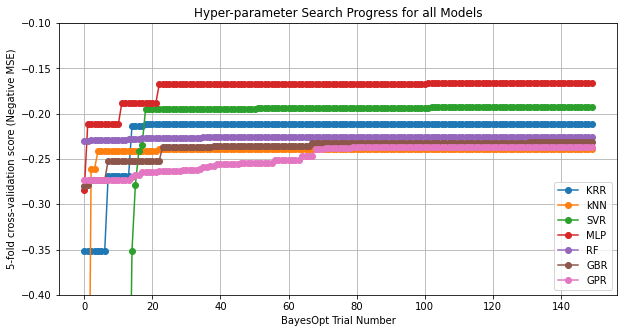

In [8]:
def compute_mse(X, y):
    scores_mse = cross_val_score(best_model, 
                                 X, y.ravel(), 
                                 cv=5, 
                                 scoring='neg_mean_squared_error')
    return -np.mean(scores_mse)

def compute_r2(X, y):
    scores_r2 = cross_val_score(best_model, 
                                X, y.ravel(), 
                                cv=5, 
                                scoring='r2')
    return np.mean(scores_r2)

mdl_names = ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR'] 
ctr = 0
plt.figure(figsize=(10,5))
for best_model in best_mdls:
    best_model.fit(X_train_scaled, y_train_scaled)
    
    print(f"{mdl_names[ctr]}")
    print("  Best cross-validation score (R2) : %.5f" % compute_r2(X_train_scaled,y_train_scaled))
    print("  Best cross-validation score (MSE): %.5f" % compute_mse(X_train_scaled,y_train_scaled))
    y_train_pred = best_model.predict(X_train_scaled)
    R2_train = r2_score(y_train_scaled,y_train_pred)
    print("  Performance on train data (R2) :  %.5f" % R2_train)
    mse_train = mean_squared_error(y_train_scaled,y_train_pred)
    print("  Performance on train data (MSE):  %.5f" % mse_train)
    y_test_pred = best_model.predict(X_test_scaled)
    R2_test = r2_score(y_test_scaled,y_test_pred)
    print("  Performance on test data (R2)  :  %.5f" % R2_test)
    mse_test = mean_squared_error(y_test_scaled,y_test_pred)
    print("  Performance on test data (MSE) :  %.5f" % mse_test)
    
    X_scaled = np.vstack((X_train_scaled, X_test_scaled))
    y_scaled = np.vstack((y_train_scaled, y_test_scaled))
    y_pred = best_model.predict(X_scaled)
    R2_all = r2_score(y_scaled, y_pred)
    print("  Performance on all data (R2)   :  %.5f" % R2_all)
    mse_all = mean_squared_error(y_scaled, y_pred)
    print("  Performance on all data (MSE)  :  %.5f" % mse_all)
    
    info_list = _get_optimization_history_info_list(studies[ctr], 
                                                    target=None,
                                                    target_name="Objective Value", 
                                                    error_bar=False)
    plt.plot(info_list[0].trial_numbers,
             info_list[0].best_values_info.values, 'o-')
    ctr+=1

plt.ylabel('5-fold cross-validation score (Negative MSE)')
plt.xlabel('BayesOpt Trial Number')
plt.title('Hyper-parameter Search Progress for all Models')
plt.legend(mdl_names)
plt.ylim((-0.4,-0.1))
plt.grid()
plt.show()
    

## Shapley Explanation on All Optuna Models

KernelRidge(alpha=0.024451252684332455, kernel='laplacian')


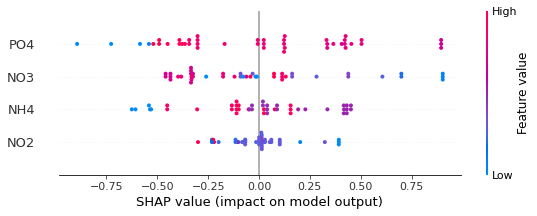

KNeighborsRegressor(n_neighbors=16, weights='distance')


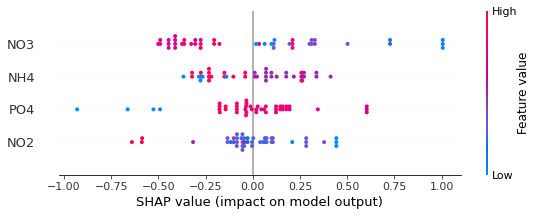

SVR(C=18.706661783641433, epsilon=0.16688034091906265, gamma=0.4990318697594256)


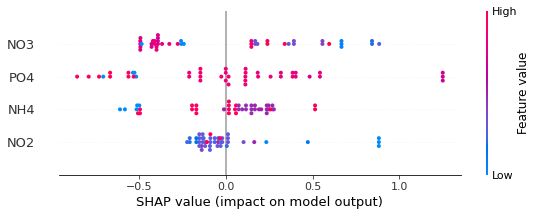

MLPRegressor(hidden_layer_sizes=(69, 79),
             learning_rate_init=0.015333338068444533, max_iter=100,
             random_state=1)


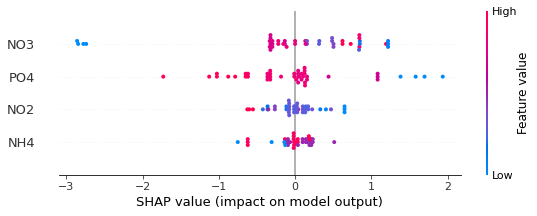

RandomForestRegressor(criterion='absolute_error', n_estimators=111,
                      random_state=42)


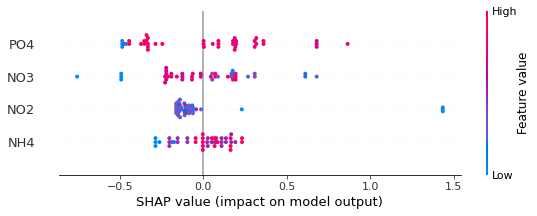

GradientBoostingRegressor(max_depth=2, n_estimators=61)


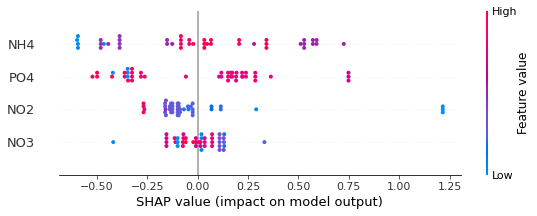

GaussianProcessRegressor(alpha=0.054720298236561875,
                         kernel=WhiteKernel(noise_level=0.236) + Matern(length_scale=0.104, nu=0.5),
                         n_restarts_optimizer=10)


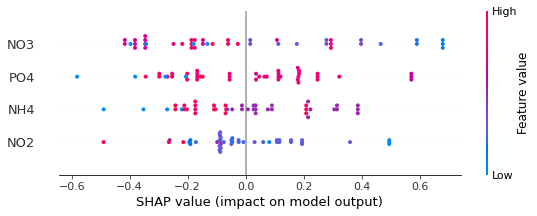

In [9]:
import shap
for best_model in best_mdls:
    print(best_model)
    shap_values = shap.KernelExplainer(best_model.predict,X_test_scaled)
    background = shap.maskers.Independent(X_test_scaled, max_samples=1000)
    explainer = shap.Explainer(best_model.predict, background)
    shap_values = explainer(X_test_scaled)

    # Plot the feature importance using SHAP
    shap.summary_plot(shap_values, X_test_scaled, feature_names=['NO2','NO3','NH4','PO4'])

## Relating Total-N/Total-P ratio to Chl-a

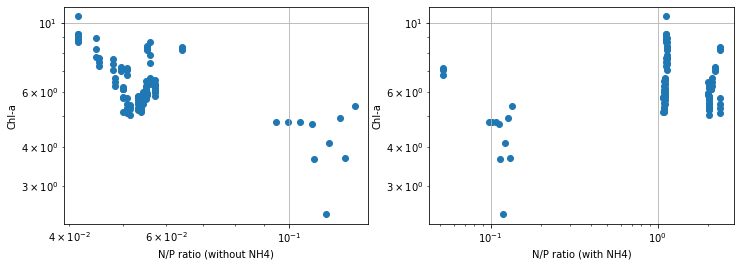

In [10]:
X2 = np.sum(X[:,:2],axis=1)/X[:,-1]
X2 = X2.reshape(-1,1)

plt.subplots(ncols=2, figsize=(12, 4))
plt.subplot(121)
plt.scatter(X2,y)
plt.ylabel('Chl-a')
plt.xlabel('N/P ratio (without NH4)')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.subplot(122)
X3 = np.sum(X[:,:3],axis=1)/X[:,-1]
plt.scatter(X3,y)
plt.ylabel('Chl-a')
plt.xlabel('N/P ratio (with NH4)')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

## Robustness Analysis due to Imperfect Measurements (using Monte Carlo)

KernelRidge(alpha=0.024451252684332455, kernel='laplacian')
Original:
  Performance on train data (R2): 0.96615
  Performance on test data (R2): 0.92503


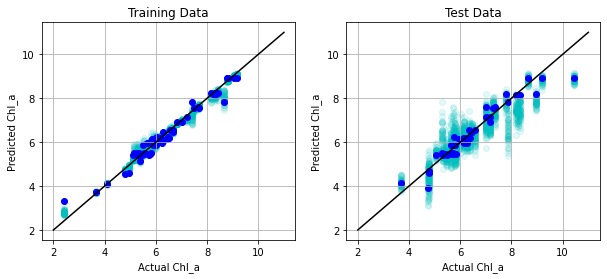

KNeighborsRegressor(n_neighbors=16, weights='distance')
Original:
  Performance on train data (R2): 0.97667
  Performance on test data (R2): 0.92307


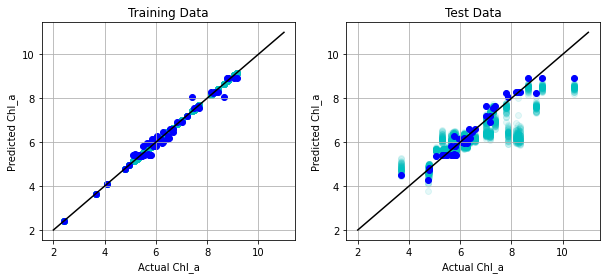

SVR(C=18.706661783641433, epsilon=0.16688034091906265, gamma=0.4990318697594256)
Original:
  Performance on train data (R2): 0.89090
  Performance on test data (R2): 0.91740


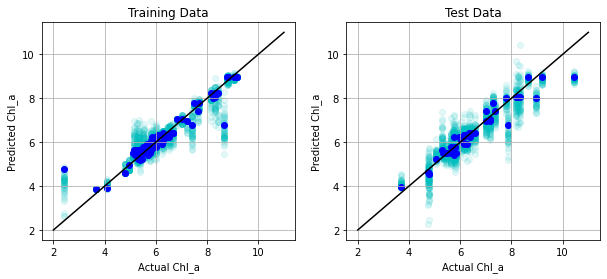

MLPRegressor(hidden_layer_sizes=(69, 79),
             learning_rate_init=0.015333338068444533, max_iter=100,
             random_state=1)
Original:
  Performance on train data (R2): 0.93111
  Performance on test data (R2): 0.91240


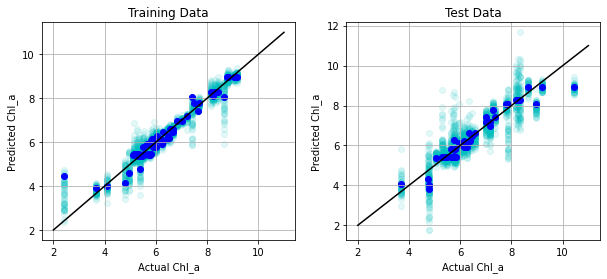

RandomForestRegressor(criterion='absolute_error', n_estimators=111,
                      random_state=42)
Original:
  Performance on train data (R2): 0.95029
  Performance on test data (R2): 0.91350


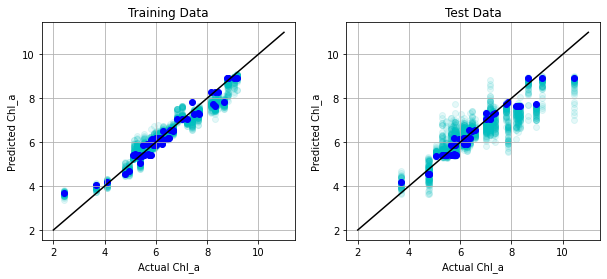

GradientBoostingRegressor(max_depth=2, n_estimators=61)
Original:
  Performance on train data (R2): 0.94532
  Performance on test data (R2): 0.91036


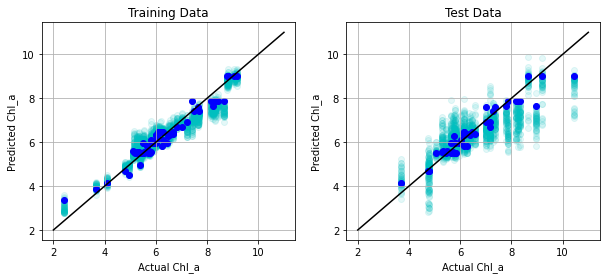

GaussianProcessRegressor(alpha=0.054720298236561875,
                         kernel=WhiteKernel(noise_level=0.236) + Matern(length_scale=0.104, nu=0.5),
                         n_restarts_optimizer=10)
Original:
  Performance on train data (R2): 0.97499
  Performance on test data (R2): 0.90525


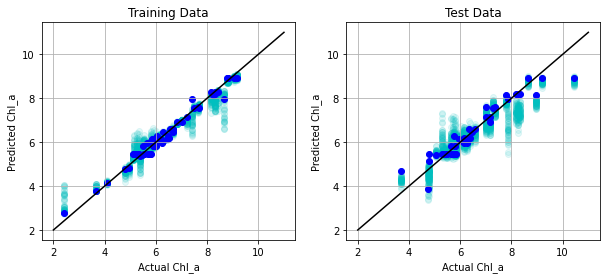

In [12]:
N = 50
ctr = 0
R2_train_all = np.zeros((N+1,7))
R2_test_all = np.zeros((N+1,7))

for best_model in best_mdls:
    
    print(best_model)
    mdl = best_model.fit(X_train_scaled, y_train_scaled)
    y_train = mdl.predict(X_train_scaled)
    y_test = mdl.predict(X_test_scaled)
    R2_train = r2_score(y_train_scaled,y_train)
    R2_test = r2_score(y_test_scaled,y_test)
    print("Original:")
    print("  Performance on train data (R2): %.5f" % R2_train)
    print("  Performance on test data (R2): %.5f" % R2_test)
    y_train_ = scaler_y.inverse_transform(y_train.reshape(-1,1))
    y_test_ = scaler_y.inverse_transform(y_test.reshape(-1,1))

    y_train_collect = y_train_
    y_test_collect = y_test_
    R2_train_collect = R2_train
    R2_test_collect = R2_test
    y_train_, y_test_ = y_train_.ravel(), y_test_.ravel()

    for i in range(N):
        np.random.RandomState(0)
        noise_train = np.random.normal(0,0.1,X_train_scaled.shape)
        noise_test = np.random.normal(0,0.1,X_test_scaled.shape)
        mdl_noise = best_model.fit(X_train_scaled + noise_train, y_train_scaled)
        y_train2 = mdl_noise.predict(X_train_scaled + noise_train)
        y_test2 = mdl_noise.predict(X_test_scaled + noise_test)
        R2_train2 = r2_score(y_train_scaled,y_train2)
        R2_test2 = r2_score(y_test_scaled,y_test2)
        R2_train_collect = np.hstack((R2_train_collect,R2_train2))
        R2_test_collect = np.hstack((R2_test_collect,R2_test2))
        y_train2_ = scaler_y.inverse_transform(y_train2.reshape(-1,1))
        y_test2_ = scaler_y.inverse_transform(y_test2.reshape(-1,1))
        y_train_collect = np.hstack((y_train_collect,y_train2_))
        y_test_collect = np.hstack((y_test_collect,y_test2_))

    y_train_true = scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).ravel()
    y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()
    R2_train_all[:,ctr] = R2_train_collect
    R2_test_all[:,ctr] = R2_test_collect
    ctr += 1

    # Sort all y according to true values
    train_id = np.argsort(y_train_true)
    test_id = np.argsort(y_test_true)
    y_train_true = y_train_true[train_id]
    y_test_true = y_test_true[test_id]
    y_train_ = y_train_[train_id]
    y_test_ = y_test_[test_id]
    y_train_collect = y_train_collect[train_id,:]
    y_test_collect = y_test_collect[test_id,:]

    plt.subplots(ncols=2, figsize=(10, 4))
    plt.subplot(121)
    for i in range(N):
        plt.scatter(y_train_true, y_train_collect[:,i], color='c', alpha=0.1)
    plt.scatter(y_train_true, y_train_, color='b')
    plt.plot([2, 11],[2, 11],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title("Training Data")
    plt.grid()
    plt.subplot(122)
    for i in range(N):
        plt.scatter(y_test_true, y_test_collect[:,i], color='c', alpha=0.1)
    plt.scatter(y_test_true, y_test_, color='b')
    plt.plot([2, 11],[2, 11],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title(f"Test Data")
    plt.grid()
    plt.savefig(f"fig_mdl{ctr}.png",dpi=900)
    plt.show()
    

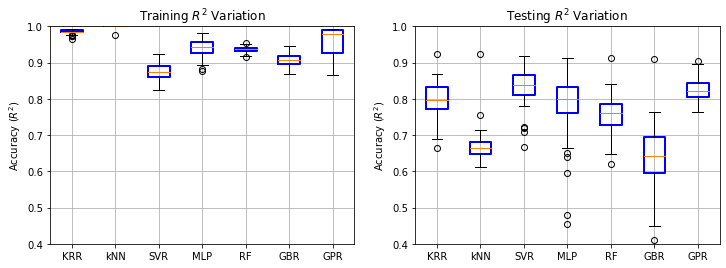

Total Runtime: 473.0226 sec


In [13]:
plt.subplots(ncols=2, figsize=(12, 4))
plt.subplot(121)
boxprops = dict(linewidth=2, color='b')
plt.boxplot(R2_train_all, boxprops=boxprops)
plt.title('Training $R^2$ Variation')
plt.xticks(np.arange(7)+1,["KRR","kNN","SVR","MLP","RF","GBR","GPR"])
plt.ylim(0.4, 1.00)
plt.ylabel('Accuracy ($R^2$)')
plt.grid()
plt.subplot(122)
plt.boxplot(R2_test_all, boxprops=boxprops)
plt.title('Testing $R^2$ Variation')
plt.xticks(np.arange(7)+1,["KRR","kNN","SVR","MLP","RF","GBR","GPR"])
plt.ylim(0.4, 1.00)
plt.ylabel('Accuracy ($R^2$)')
plt.grid()
plt.savefig('fig_robust.png',dpi=900)
plt.show()

total_time = time()-start
print("Total Runtime: %.4f sec" % total_time)

In [14]:
print(np.median(R2_train_all,axis=0))
print(np.median(R2_test_all,axis=0))

[0.98576581 1.         0.87515021 0.94279235 0.93615931 0.90665027
 0.97885016]
[0.79639434 0.66432157 0.83760259 0.80022969 0.76166128 0.64251814
 0.82153309]
